# MIMIC-IV-ED Dataset

Nome: Vinicius Anjos de Almeida

Número USP: 7625114

## Descrição
MIMIC-IV-ED é um grande dataset disponível gratuitamente, contendo passagens no departamento de emergência (ED) do Beth Israel Deaconess Medical Center entre 2011 e 2019. O banco de dados contém aproximadamente 425.000 passagens no ED. Vários dados dessas passagens estão disponíveis, incluindo sinais vitais, informações de triagem, medicamentos que o paciente utilizava até antes da internação e se o paciente foi internado no hospital ou não. 

## Plano
Utilizar dados disponíveis logo após a avaliação na triagem para prever se o paciente será internado no hospital ou não. As informações que estarão disponíveis neste momento são:
- raça
- gênero
- idade
- o meio pelo qual o paciente chegou ao hospital
- data e hora da entrada no hospital
- medicamentos em uso até antes da visita ao serviço de emergência
  - National Drug Code (NDC): O NDC, ou Código Nacional de Medicamentos, é um número único de 10 dígitos e 3 segmentos. É um identificador universal de produto para medicamentos humanos nos Estados Unidos. O código está presente em todas as embalagens e bulas de medicamentos sem receita (OTC) e com receita nos EUA.
  - Grupo ontológico
  Atenção: Note que como um medicamento pode ser classificado em múltiplos grupos na ontologia, pode haver mais de uma linha para um único medicamento. Por exemplo, o medicamento Adderall é (1) um estimulante do SNC, (2) uma terapia para Transtorno de Déficit de Atenção e Hiperatividade, e (3) uma terapia para narcolepsia.
- sinais vitais e outras avaliações objetivas, incluindo:
  - temperatura
  - frequência cardíaca
  - frequência respiratória
  - saturação de O2
  - pressão arterial sistólica
  - pressão arterial diastólica
  - dor
- nível de urgência, que é um número de 1 a 5 representando o nível de urgência do caso com base na impressão do profissional que executou a triagem. 1 representa a maior gravidade e 5 a menor gravidade.

Cada uma dessas vai virar uma proporção de admissão, e será selecionada a máxima, a média, a mínima, desvio-padrão. As proporções de admissão devem ser baseadas somente nos dados selecionados para treino.

Modelos de machine learning para testar e otimizar para a tarefa:
- Random Forest
- XGBoost
- Light GBM
- GBM
- GLM

Trabalhos anteriores não incluíram informações sobre medicamentos e excluíram dados faltantes. Neste contexto, medicamentos e dados faltantes podem revelar informações importantes sobre a gravidade do quadro do paciente e, por isso, serão incluídos aqui. Além disso, a coluna disposition em geral foi a utilizada para saber se o paciente internou ou não, porém essa coluna eventualmente tem informações discordantes da coluna hadm_id, que é a coluna com o id propriamente da internação hospitalar e que se relaciona com a tabela com dados das internações hospitalares. Por esse motivo, utilzaremos como indicador da internação a existência de um id na coluna hadm_id.

## Trabalhos anteriores

---

**A Machine Learning Pipeline Using KNIME to Predict Hospital Admission in the MIMIC-IV Database**

**Abstract:**
It is well known that overcrowding in emergency department (ED) lowers the standard of care and raises the risk of medical errors. An initial predictive supplementary tool of hospital admission at an early stage of a patient's arrival to the emergency department (ED) can provide health care professionals a number of advantages, such as, more efficient patient flow management and better hospital care. In this paper, we use data from the Medical Information Mart for Intensive Care IV Emergency Department (MIMIC-IV-ED) database to predict whether a patient will be admitted to the hospital or not. The choice of predictive attributes was driven by simplicity (a set of basic vital signs were used) so that the prediction can be made at an early stage of the patient's arrival. Several versions of Machine Learning (ML) algorithms based on Decision Trees (DT) were used for classification and prediction. An important asset of the proposed methodology is that the whole process is implemented through an ML pipeline created with an open-source, visual programming tool. The proposed methodology contains the pre-processing stage, the modelling stage includes seven classifiers, and the combined visualization of the evaluation of the predictive models. The Gradient Boosted Trees method outperforms the rest of the algorithms that were used. An accuracy of 80% can be achieved only by using early triage data.

**URL:** https://ieeexplore.ieee.org/document/10345903

---
**Machine Learning in Medical Triage: A Predictive Model for Emergency Department Disposition**

**Abstract:**
The study explores the application of automated machine learning (AutoML) using the MIMIC-IV-ED database to enhance decision-making in emergency department (ED) triage. We developed a predictive model that utilizes triage data to forecast hospital admissions, aiming to support medical staff by providing an advanced decision-support system. The model, powered by H2O.ai’s AutoML platform, was trained on approximately 280,000 preprocessed records from the Beth Israel Deaconess Medical Center collected between 2011 and 2019. The selected Gradient Boosting Machine (GBM) model demonstrated an AUC ROC of 0.8256, indicating its efficacy in predicting patient dispositions. Key variables such as acuity and waiting hours were identified as significant predictors, emphasizing the model’s capability to integrate critical triage metrics into its predictions. However, challenges related to the complexity and heterogeneity of medical data, privacy concerns, and the need for model interpretability were addressed through the incorporation of Explainable AI (XAI) techniques. These techniques ensure the transparency of the predictive processes, fostering trust and facilitating ethical AI use in clinical settings. Future work will focus on external validation and expanding the model to include a broader array of variables from diverse healthcare environments, enhancing the model’s utility and applicability in global emergency care contexts.

**URL:** https://www.mdpi.com/2076-3417/14/15/6623

---

In [1]:
#!wget -r -N -c -np --user almeidava93 --ask-password https://physionet.org/files/mimic-iv-ed/2.2/ -q

In [2]:
#!wget -r -N -c -np --user almeidava93 --ask-password https://physionet.org/files/mimiciv/3.0/hosp/patients.csv.gz -q

In [1]:
# Após download de arquivos comprimidos em .gz, descomprimir para ter acesso aos csv

import os
from pathlib import Path
import gzip
import shutil

cwd = Path(os.getcwd())

for (root,dirs,files) in os.walk(cwd/'physionet.org'):
  for file in files:
    if file.endswith('.gz'):
      compressed_file_path = Path(root, file)
      decompressed_file_path = Path(root, file[:-3])

      with gzip.open(compressed_file_path, 'rb') as f1:
        with open(decompressed_file_path, 'wb') as f2:
          shutil.copyfileobj(f1, f2)

      os.remove(compressed_file_path)
      print(f"File {decompressed_file_path} decompressed.")

In [2]:
# Carregar DataFrames com todas as tabelas

import pandas as pd

edstays_path = Path('physionet.org/files/mimic-iv-ed/2.2/ed/edstays.csv')
edstays_df = pd.read_csv(edstays_path)

diagnosis_path = Path('physionet.org/files/mimic-iv-ed/2.2/ed/diagnosis.csv')
diagnosis_df = pd.read_csv(diagnosis_path)

medrecon_path = Path('physionet.org/files/mimic-iv-ed/2.2/ed/medrecon.csv')
medrecon_df = pd.read_csv(medrecon_path)

pyxis_path = Path('physionet.org/files/mimic-iv-ed/2.2/ed/pyxis.csv')
pyxis_df = pd.read_csv(pyxis_path)

triage_path = Path('physionet.org/files/mimic-iv-ed/2.2/ed/triage.csv')
triage_df = pd.read_csv(triage_path)

vitalsign_path = Path('physionet.org/files/mimic-iv-ed/2.2/ed/vitalsign.csv')
vitalsign_df = pd.read_csv(vitalsign_path)

patients_path = Path('physionet.org/files/mimiciv/3.0/hosp/patients.csv')
patients_df = pd.read_csv(patients_path)

In [5]:
edstays_df.head()

,subject_id,hadm_id,stay_id,intime,outtime,gender,race,arrival_transport,disposition
0,10000032,22595853.0,33258284,2180-05-06 19:17:00,2180-05-06 23:30:00,F,WHITE,AMBULANCE,ADMITTED
1,10000032,22841357.0,38112554,2180-06-26 15:54:00,2180-06-26 21:31:00,F,WHITE,AMBULANCE,ADMITTED
2,10000032,25742920.0,35968195,2180-08-05 20:58:00,2180-08-06 01:44:00,F,WHITE,AMBULANCE,ADMITTED
3,10000032,29079034.0,32952584,2180-07-22 16:24:00,2180-07-23 05:54:00,F,WHITE,AMBULANCE,HOME
4,10000032,29079034.0,39399961,2180-07-23 05:54:00,2180-07-23 14:00:00,F,WHITE,AMBULANCE,ADMITTED


In [6]:
patients_df.head()

,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10000032,F,52,2180,2014 - 2016,2180-09-09
1,10000048,F,23,2126,2008 - 2010,NaN
2,10000058,F,33,2168,2020 - 2022,NaN
3,10000068,F,19,2160,2008 - 2010,NaN
4,10000084,M,72,2160,2017 - 2019,2161-02-13


In [3]:
# Organizar DataFrame único com dados de interesse
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer


data_df = pd.DataFrame()
data_df["id"] = edstays_df["stay_id"]
data_df["subject_id"] = edstays_df["subject_id"]

# Codificar dados categóricos
## Selecionar variáveis categóricas
data_df["gender"] = edstays_df["gender"]
data_df["race"] = edstays_df["race"]
data_df["arrival_transport"] = edstays_df["arrival_transport"]
categoric_cols = ["gender", "race", "arrival_transport"]
## Criar one-hot encoding de variáveis categóricas
data_df = pd.get_dummies(data_df, columns=categoric_cols)

# Incluir informações sobre a hora, o dia da semana e o mês do ano em que a visita ao serviço de emergência ocorreu
data_df['intime'] = pd.to_datetime(edstays_df['intime'])
data_df['in_day_of_the_week'] = data_df['intime'].dt.day_of_week
data_df['in_hour_of_the_day'] = data_df['intime'].dt.hour
data_df['in_month_of_the_year'] = data_df['intime'].dt.month

# Circular encoding - Padronizar dados cíclicos para representar melhor a ciclicidade presente no dado
## Selecionar variáveis cíclicas
cyclic_cols = ['in_day_of_the_week', 'in_hour_of_the_day', 'in_month_of_the_year']
## Realizar circular encoding para cada variável
for col in cyclic_cols:
  data_df[f'{col}_sin'] = np.sin(2 * np.pi * data_df[col] / len(data_df[col].unique()))
  data_df[f'{col}_cos'] = np.cos(2 * np.pi * data_df[col] / len(data_df[col].unique()))
## Deletar colunas originais
data_df.drop(columns=cyclic_cols, inplace=True)

# Incluir se o paciente foi admitido ao hospital ou não
data_df['admitted_to_hosp'] = edstays_df['hadm_id'].apply(lambda x: np.isnan(x)==False).astype(int)

# Incluir dados coletados na triagem do hospital
## Seleção das variáveis relevantes
triage_data_df = triage_df[['stay_id', 'temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'acuity', 'pain']]

## Conversão dos dados da coluna pain para dado numérico inteiro quando possível. Se não é possível, deixar como missing.
def convert_to_int(value):
    try:
        return int(value)
    except:
        return np.nan
    
triage_data_df['pain'] = triage_data_df['pain'].apply(convert_to_int)

## União das tabelas
data_df = pd.merge(data_df, triage_data_df, left_on='id', right_on='stay_id', how='left')

# Incluir dado de idade do paciente ('anchor_age')
patients_age_df = patients_df[['subject_id', 'anchor_age']]
## União das tabelas através do id do paciente
data_df = pd.merge(data_df, patients_age_df, left_on='subject_id', right_on='subject_id', how='left')

# Tratar dados faltantes
## Criar coluna com one-hot encoding definindo se existe valor faltando ou não para aquela variável
cols_with_missing_values = []
for col in data_df.columns:
  if data_df[col].isna().any():
    cols_with_missing_values.append(col)
    data_df[f'{col}_is_missing'] = data_df[col].isna().astype(int)

# Reunir dados relativos os medicamentos que os pacientes faziam uso até antes de passarem na emergência
# Reunir por cada código disponível, que considera princípio ativo e grupo de medicamentos
# Pegar lista de códigos NDC (National Drug Code) de medicamentos e associar a cada stay_id
med_by_stay_id_ndc = medrecon_df.groupby('stay_id')['ndc'].unique()
data_df = pd.merge(data_df, med_by_stay_id_ndc, left_on='id', right_on='stay_id', how='left')

# Pegar lista de códigos etccode de medicamentos e associar a cada stay_id
med_by_stay_id_etccode = medrecon_df.groupby('stay_id')['etccode'].unique()
data_df = pd.merge(data_df, med_by_stay_id_etccode, left_on='id', right_on='stay_id', how='left')

# Pegar lista de códigos Generic Sequence Number (GSN) de medicamentos e associar a cada stay_id
med_by_stay_id_gsn = medrecon_df.groupby('stay_id')['gsn'].unique()
data_df = pd.merge(data_df, med_by_stay_id_gsn, left_on='id', right_on='stay_id', how='left')

# Pegar lista nomes de medicamentos e associar a cada stay_id
med_by_stay_id_name = medrecon_df.groupby('stay_id')['name'].unique()
data_df = pd.merge(data_df, med_by_stay_id_name, left_on='id', right_on='stay_id', how='left')


C:\Users\Vinicius\AppData\Local\Temp\ipykernel_29172\2926409353.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  triage_data_df['pain'] = triage_data_df['pain'].apply(convert_to_int)


In [4]:
# Incluir número de medicamentos que o paciente usava antes da passagem na emergência
# Vamos incluir a contagem de medicamentos segundo cada coluna, já que elas podem ter valores diferentes por conta de se tratar uma codificação diferente

import numpy as np

def get_len(list):
    if list is np.nan:
        return 0
    else:
        return len(list)

# Pegar o número de medicamentos segundo códigos NDC únicos 
data_df['med_count_by_ndc'] = data_df['ndc'].apply(get_len)
# Pegar o número de medicamentos segundo códigos ETC únicos 
data_df['med_count_by_etccode'] = data_df['etccode'].apply(get_len)
# Pegar o número de medicamentos segundo nomes únicos de medicamentos 
data_df['med_count_by_name'] = data_df['name'].apply(get_len)
# Pegar o número de medicamentos segundo códigos GSN únicos 
data_df['med_count_by_gsn'] = data_df['gsn'].apply(get_len)

In [5]:
# Criar coluna enfatizando o fato de o paciente não usar nenhuma medicação continuamente até o momento da passagem na emergência
data_df['use_no_medication'] = data_df['med_count_by_ndc']==0

In [6]:
# Preparar datasets
random_state = 42
## Separar variáveis preditoras da variável a ser predita
X = data_df.drop('admitted_to_hosp', axis=1)
y = data_df['admitted_to_hosp']
## Separar em dataset de treino (90%) e teste (10%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state)
## Separar dados de treino em treino (90%) e validação (10%)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=random_state)

### Target encoding de medicamentos
Proporções de internações calculadas com base em:
- códigos NDC
- códigos ETC
- nomes de medicamentos
- códigos GSN

In [7]:
# Separar dados de medicamentos para target encoding utilizando dados do dataset de treino
medrecon_train_df = medrecon_df[medrecon_df["stay_id"].isin(X_train["id"])]

#### Proporção de admissões por código NDC de medicamentos

In [8]:
# Agrupar medicamentos por código NDC presentes no dataset de treino e as passagens na emergência
med_adm_prop_by_ndc = medrecon_train_df.groupby('ndc')['stay_id'].unique().reset_index()

# Calcular a proporção das passagens na emergência em que havia uso do medicamento com um nome específico e que terminaram em admissão hospitalar
med_adm_prop_by_ndc['admission_proportion_by_ndc'] = med_adm_prop_by_ndc['stay_id'].apply(
    lambda stay_ids: edstays_df[edstays_df["stay_id"].isin(stay_ids)]['hadm_id'].notna().mean()
)
# med_adm_prop_by_ndc é a referência para a proporção de admissão relacionada a cada medicamento
med_adm_prop_by_ndc.drop(columns=['stay_id'], inplace=True)

# Usar chance de admissão geral dos dados de treino caso não haja medicamentos em uso com código NDC
general_admission_proportion = y_train.value_counts(normalize=True).iloc[1]

In [9]:
# Definir função que estima chance de internação baseada nos códigos NDC.
def estimate_max_admission_proportion_by_ndc(ndc_list):
  if ndc_list is None or ndc_list is np.nan:
    return general_admission_proportion
  # Entre os medicamentos em uso, selecionar o valor correspondente ao de maior chance de internação
  return med_adm_prop_by_ndc[med_adm_prop_by_ndc['ndc'].isin(ndc_list)]['admission_proportion_by_ndc'].max()

X_train['ndc_max_adm_prop'] = X_train['ndc'].apply(estimate_max_admission_proportion_by_ndc)
X_val['ndc_max_adm_prop'] = X_val['ndc'].apply(estimate_max_admission_proportion_by_ndc)
X_test['ndc_max_adm_prop'] = X_test['ndc'].apply(estimate_max_admission_proportion_by_ndc)

In [10]:
# Definir função que estima chance de internação baseada nos códigos NDC.
def estimate_mean_admission_proportion_by_ndc(ndc_list):
  if ndc_list is None or ndc_list is np.nan:
    return general_admission_proportion
  # Entre os medicamentos em uso, selecionar o valor correspondente à média das chances de internação de cada medicamento
  return med_adm_prop_by_ndc[med_adm_prop_by_ndc['ndc'].isin(ndc_list)]['admission_proportion_by_ndc'].mean()

X_train['ndc_mean_adm_prop'] = X_train['ndc'].apply(estimate_mean_admission_proportion_by_ndc)
X_val['ndc_mean_adm_prop'] = X_val['ndc'].apply(estimate_mean_admission_proportion_by_ndc)
X_test['ndc_mean_adm_prop'] = X_test['ndc'].apply(estimate_mean_admission_proportion_by_ndc)

In [11]:
# Definir função que estima chance de internação baseada nos códigos NDC.
def estimate_min_admission_proportion_by_ndc(ndc_list):
  if ndc_list is None or ndc_list is np.nan:
    return general_admission_proportion
  # Entre os medicamentos em uso, selecionar o valor correspondente ao valor mínimo das chances de internação de cada medicamento
  return med_adm_prop_by_ndc[med_adm_prop_by_ndc['ndc'].isin(ndc_list)]['admission_proportion_by_ndc'].min()

X_train['ndc_min_adm_prop'] = X_train['ndc'].apply(estimate_min_admission_proportion_by_ndc)
X_val['ndc_min_adm_prop'] = X_val['ndc'].apply(estimate_min_admission_proportion_by_ndc)
X_test['ndc_min_adm_prop'] = X_test['ndc'].apply(estimate_min_admission_proportion_by_ndc)

In [12]:
# Definir função que estima chance de internação baseada nos códigos NDC.
def estimate_std_admission_proportion_by_ndc(ndc_list):
  if ndc_list is None or ndc_list is np.nan:
    return general_admission_proportion
  # Entre os medicamentos em uso, selecionar o valor correspondente ao valor std das chances de internação de cada medicamento
  return med_adm_prop_by_ndc[med_adm_prop_by_ndc['ndc'].isin(ndc_list)]['admission_proportion_by_ndc'].std()

X_train['ndc_std_adm_prop'] = X_train['ndc'].apply(estimate_std_admission_proportion_by_ndc)
X_val['ndc_std_adm_prop'] = X_val['ndc'].apply(estimate_std_admission_proportion_by_ndc)
X_test['ndc_std_adm_prop'] = X_test['ndc'].apply(estimate_std_admission_proportion_by_ndc)

#### Proporção de admissões por código ETC de medicamentos

In [13]:
# Agrupar medicamentos por código etc presentes no dataset de treino e as passagens na emergência
med_adm_prop_by_etc = medrecon_train_df.groupby('etccode')['stay_id'].unique().reset_index()

# Calcular a proporção das passagens na emergência em que havia uso do medicamento com um nome específico e que terminaram em admissão hospitalar
med_adm_prop_by_etc['admission_proportion_by_etc'] = med_adm_prop_by_etc['stay_id'].apply(
    lambda stay_ids: edstays_df[edstays_df["stay_id"].isin(stay_ids)]['hadm_id'].notna().mean()
)
# med_adm_prop_by_etc é a referência para a proporção de admissão relacionada a cada medicamento
med_adm_prop_by_etc.drop(columns=['stay_id'], inplace=True)

# Usar chance de admissão geral dos dados de treino caso não haja medicamentos em uso com código etc
general_admission_proportion = y_train.value_counts(normalize=True).iloc[1]

In [14]:
# Definir função que estima chance de internação baseada nos códigos etc.
def estimate_max_admission_proportion_by_etc(etc_list):
  if etc_list is None or etc_list is np.nan:
    return general_admission_proportion
  # Entre os medicamentos em uso, selecionar o valor correspondente ao valor max das chances de internação de cada medicamento
  return med_adm_prop_by_etc[med_adm_prop_by_etc['etccode'].isin(etc_list)]['admission_proportion_by_etc'].max()

X_train['etc_max_adm_prop'] = X_train['etccode'].apply(estimate_max_admission_proportion_by_etc)
X_val['etc_max_adm_prop'] = X_val['etccode'].apply(estimate_max_admission_proportion_by_etc)
X_test['etc_max_adm_prop'] = X_test['etccode'].apply(estimate_max_admission_proportion_by_etc)

In [15]:
# Definir função que estima chance de internação baseada nos códigos etc.
def estimate_mean_admission_proportion_by_etc(etc_list):
  if etc_list is None or etc_list is np.nan:
    return general_admission_proportion
  # Entre os medicamentos em uso, selecionar o valor correspondente ao valor mean das chances de internação de cada medicamento
  return med_adm_prop_by_etc[med_adm_prop_by_etc['etccode'].isin(etc_list)]['admission_proportion_by_etc'].mean()

X_train['etc_mean_adm_prop'] = X_train['etccode'].apply(estimate_mean_admission_proportion_by_etc)
X_val['etc_mean_adm_prop'] = X_val['etccode'].apply(estimate_mean_admission_proportion_by_etc)
X_test['etc_mean_adm_prop'] = X_test['etccode'].apply(estimate_mean_admission_proportion_by_etc)

In [16]:
# Definir função que estima chance de internação baseada nos códigos etc.
def estimate_min_admission_proportion_by_etc(etc_list):
  if etc_list is None or etc_list is np.nan:
    return general_admission_proportion
  # Entre os medicamentos em uso, selecionar o valor correspondente ao valor min das chances de internação de cada medicamento
  return med_adm_prop_by_etc[med_adm_prop_by_etc['etccode'].isin(etc_list)]['admission_proportion_by_etc'].min()

X_train['etc_min_adm_prop'] = X_train['etccode'].apply(estimate_min_admission_proportion_by_etc)
X_val['etc_min_adm_prop'] = X_val['etccode'].apply(estimate_min_admission_proportion_by_etc)
X_test['etc_min_adm_prop'] = X_test['etccode'].apply(estimate_min_admission_proportion_by_etc)

In [17]:
# Definir função que estima chance de internação baseada nos códigos etc.
def estimate_std_admission_proportion_by_etc(etc_list):
  if etc_list is None or etc_list is np.nan:
    return general_admission_proportion
  # Entre os medicamentos em uso, selecionar o valor correspondente ao valor std das chances de internação de cada medicamento
  return med_adm_prop_by_etc[med_adm_prop_by_etc['etccode'].isin(etc_list)]['admission_proportion_by_etc'].std()

X_train['etc_std_adm_prop'] = X_train['etccode'].apply(estimate_std_admission_proportion_by_etc)
X_val['etc_std_adm_prop'] = X_val['etccode'].apply(estimate_std_admission_proportion_by_etc)
X_test['etc_std_adm_prop'] = X_test['etccode'].apply(estimate_std_admission_proportion_by_etc)

#### Proporção de admissões por código GSN de medicamentos

In [18]:
# Agrupar medicamentos por código GSN presentes no dataset de treino e as passagens na emergência
med_adm_prop_by_gsn = medrecon_train_df.groupby('gsn')['stay_id'].unique().reset_index()

In [19]:
# Calcular a proporção das passagens na emergência em que havia uso do medicamento com um nome específico e que terminaram em admissão hospitalar
med_adm_prop_by_gsn['admission_proportion_by_gsn'] = med_adm_prop_by_gsn['stay_id'].apply(
    lambda stay_ids: edstays_df[edstays_df["stay_id"].isin(stay_ids)]['hadm_id'].notna().mean()
)
# med_adm_prop_by_gsn é a referência para a proporção de admissão relacionada a cada medicamento
med_adm_prop_by_gsn.drop(columns=['stay_id'], inplace=True)

In [20]:
# Usar chance de admissão geral dos dados de treino caso não haja medicamentos em uso com código GSN
general_admission_proportion = y_train.value_counts(normalize=True).iloc[1]

# Definir função que estima chance de internação baseada nos códigos GSN.
def estimate_max_admission_proportion_by_gsn(gsn_list):
  if gsn_list is None or gsn_list is np.nan:
    return general_admission_proportion
  # Entre os medicamentos em uso, selecionar o valor correspondente ao de maior chance de internação
  return med_adm_prop_by_gsn[med_adm_prop_by_gsn['gsn'].isin(gsn_list)]['admission_proportion_by_gsn'].max()

X_train['gsn_max_adm_prop'] = X_train['gsn'].apply(estimate_max_admission_proportion_by_gsn)
X_val['gsn_max_adm_prop'] = X_val['gsn'].apply(estimate_max_admission_proportion_by_gsn)
X_test['gsn_max_adm_prop'] = X_test['gsn'].apply(estimate_max_admission_proportion_by_gsn)

In [21]:
# Definir função que estima chance de internação baseada nos códigos GSN.
def estimate_mean_admission_proportion_by_gsn(gsn_list):
  if gsn_list is None or gsn_list is np.nan:
    return general_admission_proportion
  # Entre os medicamentos em uso, selecionar o valor correspondente à média entre as chances de internação
  return med_adm_prop_by_gsn[med_adm_prop_by_gsn['gsn'].isin(gsn_list)]['admission_proportion_by_gsn'].mean()

X_train['gsn_mean_adm_prop'] = X_train['gsn'].apply(estimate_mean_admission_proportion_by_gsn)
X_val['gsn_mean_adm_prop'] = X_val['gsn'].apply(estimate_mean_admission_proportion_by_gsn)
X_test['gsn_mean_adm_prop'] = X_test['gsn'].apply(estimate_mean_admission_proportion_by_gsn)

In [22]:
# Definir função que estima chance de internação baseada nos códigos GSN.
def estimate_min_admission_proportion_by_gsn(gsn_list):
  if gsn_list is None or gsn_list is np.nan:
    return general_admission_proportion
  # Entre os medicamentos em uso, selecionar o valor correspondente ao valor mínimo entre as chances de internação
  return med_adm_prop_by_gsn[med_adm_prop_by_gsn['gsn'].isin(gsn_list)]['admission_proportion_by_gsn'].min()

X_train['gsn_min_adm_prop'] = X_train['gsn'].apply(estimate_min_admission_proportion_by_gsn)
X_val['gsn_min_adm_prop'] = X_val['gsn'].apply(estimate_min_admission_proportion_by_gsn)
X_test['gsn_min_adm_prop'] = X_test['gsn'].apply(estimate_min_admission_proportion_by_gsn)

In [23]:
# Definir função que estima chance de internação baseada nos códigos GSN.
def estimate_std_admission_proportion_by_gsn(gsn_list):
  if gsn_list is None or gsn_list is np.nan:
    return general_admission_proportion
  # Entre os medicamentos em uso, selecionar o valor correspondente ao valor std entre as chances de internação
  return med_adm_prop_by_gsn[med_adm_prop_by_gsn['gsn'].isin(gsn_list)]['admission_proportion_by_gsn'].std()

X_train['gsn_std_adm_prop'] = X_train['gsn'].apply(estimate_std_admission_proportion_by_gsn)
X_val['gsn_std_adm_prop'] = X_val['gsn'].apply(estimate_std_admission_proportion_by_gsn)
X_test['gsn_std_adm_prop'] = X_test['gsn'].apply(estimate_std_admission_proportion_by_gsn)

#### Proporção de admissões por nome de medicamentos

In [24]:
# Agrupar medicamentos por código name presentes no dataset de treino e as passagens na emergência
med_adm_prop_by_name = medrecon_train_df.groupby('name')['stay_id'].unique().reset_index()

# Calcular a proporção das passagens na emergência em que havia uso do medicamento com um nome específico e que terminaram em admissão hospitalar
med_adm_prop_by_name['admission_proportion_by_name'] = med_adm_prop_by_name['stay_id'].apply(
    lambda stay_ids: edstays_df[edstays_df["stay_id"].isin(stay_ids)]['hadm_id'].notna().mean()
)
# med_adm_prop_by_name é a referência para a proporção de admissão relacionada a cada medicamento
med_adm_prop_by_name.drop(columns=['stay_id'], inplace=True)

# Usar chance de admissão geral dos dados de treino caso não haja medicamentos em uso com código name
general_admission_proportion = y_train.value_counts(normalize=True).iloc[1]

In [25]:
# Definir função que estima chance de internação baseada nos códigos name.
def estimate_max_admission_proportion_by_name(name_list):
  if name_list is None or name_list is np.nan:
    return general_admission_proportion
  # Entre os medicamentos em uso, selecionar o valor correspondente ao valor máximo entre as chances de internação de cada nome de medicamento
  return med_adm_prop_by_name[med_adm_prop_by_name['name'].isin(name_list)]['admission_proportion_by_name'].max()

X_train['med_name_max_adm_prop'] = X_train['name'].apply(estimate_max_admission_proportion_by_name)
X_val['med_name_max_adm_prop'] = X_val['name'].apply(estimate_max_admission_proportion_by_name)
X_test['med_name_max_adm_prop'] = X_test['name'].apply(estimate_max_admission_proportion_by_name)

In [26]:
# Definir função que estima chance de internação baseada nos códigos name.
def estimate_mean_admission_proportion_by_name(name_list):
  if name_list is None or name_list is np.nan:
    return general_admission_proportion
  # Entre os medicamentos em uso, selecionar o valor correspondente ao valor mean entre as chances de internação de cada nome de medicamento
  return med_adm_prop_by_name[med_adm_prop_by_name['name'].isin(name_list)]['admission_proportion_by_name'].mean()

X_train['med_name_mean_adm_prop'] = X_train['name'].apply(estimate_mean_admission_proportion_by_name)
X_val['med_name_mean_adm_prop'] = X_val['name'].apply(estimate_mean_admission_proportion_by_name)
X_test['med_name_mean_adm_prop'] = X_test['name'].apply(estimate_mean_admission_proportion_by_name)

In [27]:
# Definir função que estima chance de internação baseada nos códigos name.
def estimate_min_admission_proportion_by_name(name_list):
  if name_list is None or name_list is np.nan:
    return general_admission_proportion
  # Entre os medicamentos em uso, selecionar o valor correspondente ao valor min entre as chances de internação de cada nome de medicamento
  return med_adm_prop_by_name[med_adm_prop_by_name['name'].isin(name_list)]['admission_proportion_by_name'].min()

X_train['med_name_min_adm_prop'] = X_train['name'].apply(estimate_min_admission_proportion_by_name)
X_val['med_name_min_adm_prop'] = X_val['name'].apply(estimate_min_admission_proportion_by_name)
X_test['med_name_min_adm_prop'] = X_test['name'].apply(estimate_min_admission_proportion_by_name)

In [28]:
# Definir função que estima chance de internação baseada nos códigos name.
def estimate_std_admission_proportion_by_name(name_list):
  if name_list is None or name_list is np.nan:
    return general_admission_proportion
  # Entre os medicamentos em uso, selecionar o valor correspondente ao valor std entre as chances de internação de cada nome de medicamento
  return med_adm_prop_by_name[med_adm_prop_by_name['name'].isin(name_list)]['admission_proportion_by_name'].std()

X_train['med_name_std_adm_prop'] = X_train['name'].apply(estimate_std_admission_proportion_by_name)
X_val['med_name_std_adm_prop'] = X_val['name'].apply(estimate_std_admission_proportion_by_name)
X_test['med_name_std_adm_prop'] = X_test['name'].apply(estimate_std_admission_proportion_by_name)

#### Inspecionar dados numéricos com base nos dados de treino

In [29]:
## Selecionar dados numéricos
numeric_cols = ['anchor_age','temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'acuity', 'pain', 'etc_min_adm_prop', 'etc_mean_adm_prop', 'etc_max_adm_prop', 'ndc_min_adm_prop', 'ndc_mean_adm_prop', 'ndc_max_adm_prop', 'med_count_by_etccode', 'med_count_by_ndc','med_count_by_name','med_count_by_gsn', 'med_name_min_adm_prop', 'med_name_mean_adm_prop', 'med_name_max_adm_prop', 'gsn_min_adm_prop', 'gsn_mean_adm_prop', 'gsn_max_adm_prop','med_name_std_adm_prop','gsn_std_adm_prop','etc_std_adm_prop','ndc_std_adm_prop']

In [30]:
X_train[numeric_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
anchor_age,344256.0,50.345641,20.094372,18.0,32.000000,50.000000,66.000000,91.000000
temperature,325344.0,98.020863,4.270164,0.1,97.500000,98.000000,98.600000,986.000000
heartrate,330470.0,85.080623,18.066636,1.0,72.000000,84.000000,96.000000,1228.000000
resprate,327789.0,17.558600,4.033645,0.0,16.000000,18.000000,18.000000,1797.900000
o2sat,327689.0,98.488460,18.762757,0.0,97.000000,99.000000,100.000000,9322.000000
sbp,329493.0,135.470411,266.993993,1.0,120.000000,133.000000,148.000000,151103.000000
dbp,328840.0,81.454166,1163.365824,0.0,68.000000,77.000000,87.000000,661672.000000
acuity,338559.0,2.625070,0.707989,1.0,2.000000,3.000000,3.000000,5.000000
pain,321121.0,4.420524,4.068748,-1.0,0.000000,5.000000,8.000000,134.000000
etc_min_adm_prop,342256.0,0.500207,0.082104,0.0,0.477605,0.483801,0.553129,0.900000


##### Investigar colinearidade

In [52]:
corr = X_train[numeric_cols].corr()
corr

,anchor_age,temperature,heartrate,resprate,o2sat,sbp,dbp,acuity,pain,etc_min_adm_prop,...,med_name_min_adm_prop,med_name_mean_adm_prop,med_name_max_adm_prop,gsn_min_adm_prop,gsn_mean_adm_prop,gsn_max_adm_prop,med_name_std_adm_prop,gsn_std_adm_prop,etc_std_adm_prop,ndc_std_adm_prop
anchor_age,1.000000,-0.015840,-0.159401,0.066058,-0.027141,0.014907,-0.002533,-0.241425,-0.132845,0.286403,...,0.226039,0.481920,0.483122,0.239761,0.492326,0.484576,-0.405231,-0.402025,-0.393226,-0.401164
temperature,-0.015840,1.000000,0.045860,0.006974,-0.000538,0.027113,-0.000176,-0.002458,0.009978,-0.003074,...,-0.000569,-0.004763,-0.004124,-0.000913,-0.004767,-0.004448,0.006629,0.006668,0.006559,0.006614
heartrate,-0.159401,0.045860,1.000000,0.086059,-0.007997,0.000693,0.000942,-0.117043,0.030201,-0.054815,...,-0.036346,-0.042824,-0.032731,-0.042777,-0.042872,-0.030469,0.025223,0.025485,0.024063,0.025440
resprate,0.066058,0.006974,0.086059,1.000000,-0.005724,0.001102,-0.000174,-0.107070,0.004781,0.013491,...,0.015642,0.055730,0.066022,0.012058,0.057152,0.066856,-0.044978,-0.044009,-0.043157,-0.043861
o2sat,-0.027141,-0.000538,-0.007997,-0.005724,1.000000,0.000416,0.000197,0.021394,0.004719,-0.008262,...,-0.007798,-0.016774,-0.017271,-0.008678,-0.017300,-0.017482,0.010414,0.010379,0.010142,0.010307
sbp,0.014907,0.027113,0.000693,0.001102,0.000416,1.000000,0.003648,0.002177,0.002176,0.006806,...,0.004106,0.007497,0.006391,0.004576,0.007187,0.006001,-0.050096,-0.050716,-0.050006,-0.050903
dbp,-0.002533,-0.000176,0.000942,-0.000174,0.000197,0.003648,1.000000,0.000919,0.001569,-0.001952,...,-0.001333,-0.000400,-0.000328,-0.000492,-0.000195,-0.000518,-0.000406,-0.000729,-0.000659,-0.000721
acuity,-0.241425,-0.002458,-0.117043,-0.107070,0.021394,0.002177,0.000919,1.000000,0.131784,-0.098758,...,-0.105309,-0.192994,-0.194074,-0.098645,-0.194895,-0.194459,0.132559,0.129325,0.128329,0.129085
pain,-0.132845,0.009978,0.030201,0.004781,0.004719,0.002176,0.001569,0.131784,1.000000,-0.078305,...,-0.069504,-0.067603,-0.051060,-0.076662,-0.072337,-0.052169,0.028599,0.027994,0.027923,0.028014
etc_min_adm_prop,0.286403,-0.003074,-0.054815,0.013491,-0.008262,0.006806,-0.001952,-0.098758,-0.078305,1.000000,...,0.756868,0.603425,0.316249,0.855346,0.617416,0.324322,-0.277244,-0.279305,-0.286587,-0.280111


<Axes: >

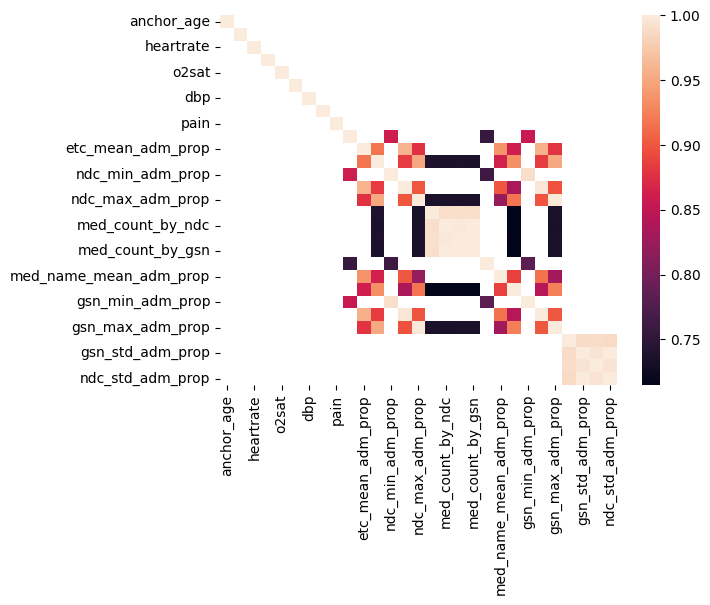

In [53]:
# Visualizar variáveis com alta colinearidade (acima de 0.7)
import seaborn as sns

sns.heatmap(corr[corr>0.7])

In [54]:
# Selecionar os nomes das variáveis com alta colinearidade
upper = corr.where(np.triu(np.ones(corr.abs().shape), k=1).astype(bool))
high_corr_features = [column for column in upper.columns if any(upper[column] > 0.7)]


In [57]:
high_corr_features

['etc_max_adm_prop',
 'ndc_min_adm_prop',
 'ndc_mean_adm_prop',
 'ndc_max_adm_prop',
 'med_count_by_etccode',
 'med_count_by_ndc',
 'med_count_by_name',
 'med_count_by_gsn',
 'med_name_min_adm_prop',
 'med_name_mean_adm_prop',
 'med_name_max_adm_prop',
 'gsn_min_adm_prop',
 'gsn_mean_adm_prop',
 'gsn_max_adm_prop',
 'gsn_std_adm_prop',
 'etc_std_adm_prop',
 'ndc_std_adm_prop']

<Axes: >

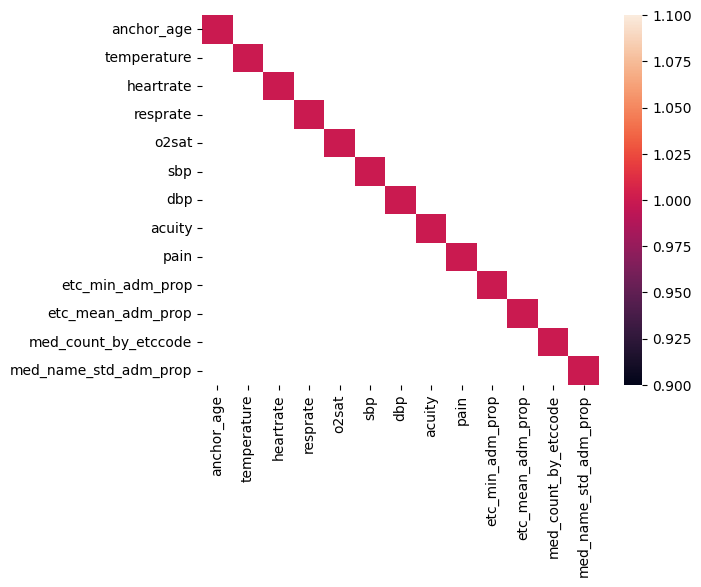

In [55]:
high_corr_features_to_drop = [
    'etc_std_adm_prop',
     'ndc_min_adm_prop',
 'ndc_mean_adm_prop',
 'ndc_max_adm_prop',
    'ndc_std_adm_prop',
    'gsn_std_adm_prop',
     'med_count_by_ndc',
 'med_count_by_name',
 'med_count_by_gsn',
 'med_name_min_adm_prop',
 'med_name_mean_adm_prop',
 'med_name_max_adm_prop',
 'gsn_min_adm_prop',
 'gsn_mean_adm_prop',
 'gsn_max_adm_prop',
 'etc_max_adm_prop',
]

corr = X_train[numeric_cols].drop(columns=high_corr_features_to_drop).corr()
sns.heatmap(corr[corr>0.7])

##### Boxplots

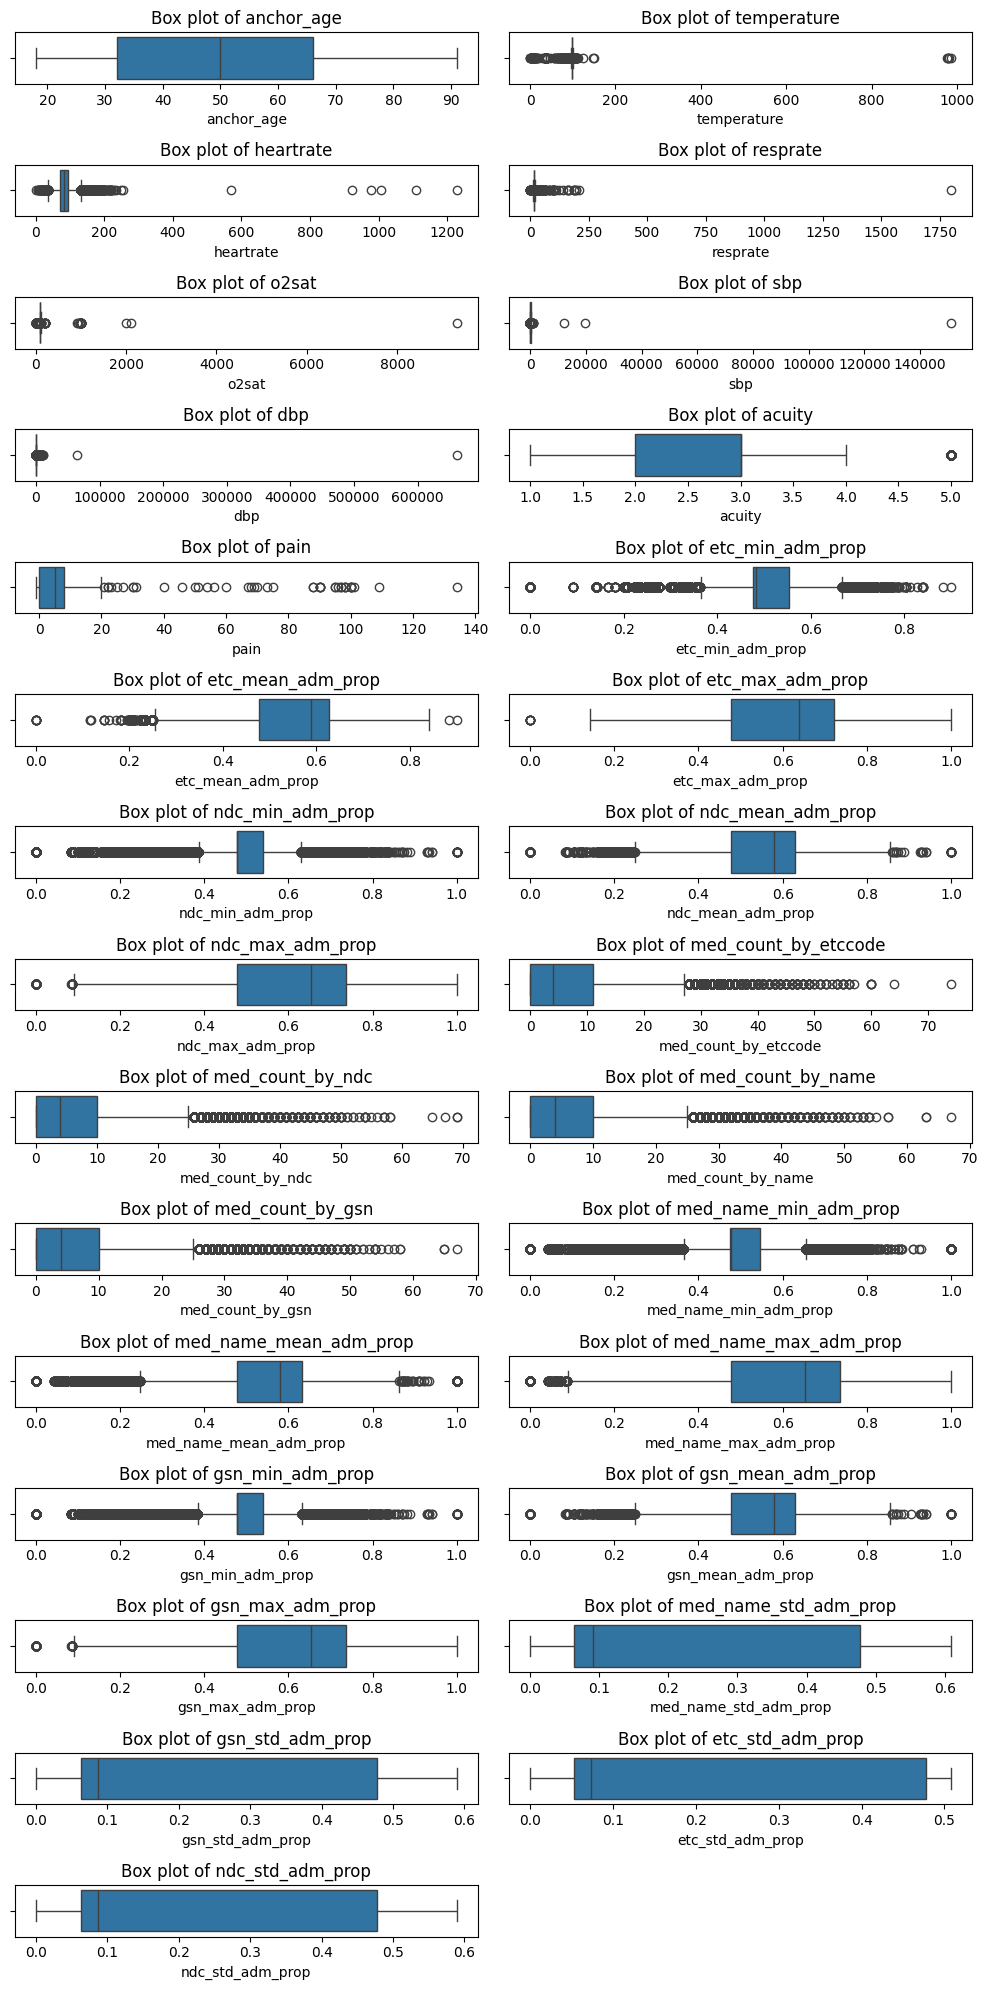

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 20))

for i, feature in enumerate(numeric_cols, 1):
    plt.subplot(15, 2, i)  # Use a flat index and start from 1
    sns.boxplot(x=X_train[feature])
    plt.title(f'Box plot of {feature}')

plt.tight_layout()
plt.show()

In [59]:
# Ajustar valores claramente equivocados nas variáveis
## temperature
X_train.loc[X_train['temperature'] > 200, 'temperature'] = np.nan
X_val.loc[X_val['temperature'] > 200, 'temperature'] = np.nan
X_test.loc[X_test['temperature'] > 200, 'temperature'] = np.nan

In [60]:
## heartrate
X_train.loc[X_train['heartrate'] > 400, 'heartrate'] = np.nan
X_val.loc[X_val['heartrate'] > 400, 'heartrate'] = np.nan
X_test.loc[X_test['heartrate'] > 400, 'heartrate'] = np.nan

In [61]:
## resprate
X_train.loc[X_train['resprate'] > 60, 'resprate'] = np.nan
X_val.loc[X_val['resprate'] > 60, 'resprate'] = np.nan
X_test.loc[X_test['resprate'] > 60, 'resprate'] = np.nan

In [62]:
## o2sat
X_train.loc[X_train['o2sat'] > 100, 'o2sat'] = np.nan
X_val.loc[X_val['o2sat'] > 100, 'o2sat'] = np.nan
X_test.loc[X_test['o2sat'] > 100, 'o2sat'] = np.nan

In [63]:
## sbp
X_train.loc[X_train['sbp'] > 300, 'sbp'] = np.nan
X_val.loc[X_val['sbp'] > 300, 'sbp'] = np.nan
X_test.loc[X_test['sbp'] > 300, 'sbp'] = np.nan

In [64]:
## dbp
X_train.loc[X_train['dbp'] > 300, 'dbp'] = np.nan
X_val.loc[X_val['dbp'] > 300, 'dbp'] = np.nan
X_test.loc[X_test['dbp'] > 300, 'dbp'] = np.nan

In [65]:
## pain - Considerar apenas valores entre 0 e 10
X_train.loc[(X_train['pain'] > 10)|(X_train['pain'] < 0), 'pain'] = np.nan
X_val.loc[(X_val['pain'] > 10)|(X_val['pain'] < 0), 'pain'] = np.nan
X_test.loc[(X_test['pain'] > 10)|(X_test['pain'] < 0), 'pain'] = np.nan

#### Realizar padronização dos dados segundo dados de treino

In [66]:
# Normalizar dados numéricos
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
## Dados de treino
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
## Aplicar o mesmo scaler aos dados de validação e teste
X_val[numeric_cols] = scaler.transform(X_val[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])


#### Inspeção dos dados categóricos

In [67]:
bool_cols = X_train.select_dtypes(include='bool').columns

# tabelas de frequências com porcentagens, se quiser com frequencias absolutas tirar o normalize
for col in bool_cols:
    print(X_train[col].value_counts(normalize=True).sort_index(), end='\n\n')

gender_F
False    0.459061
True     0.540939
Name: proportion, dtype: float64

gender_M
False    0.540939
True     0.459061
Name: proportion, dtype: float64

race_AMERICAN INDIAN/ALASKA NATIVE
False    0.997505
True     0.002495
Name: proportion, dtype: float64

race_ASIAN
False    0.98276
True     0.01724
Name: proportion, dtype: float64

race_ASIAN - ASIAN INDIAN
False    0.996364
True     0.003636
Name: proportion, dtype: float64

race_ASIAN - CHINESE
False    0.982752
True     0.017248
Name: proportion, dtype: float64

race_ASIAN - KOREAN
False    0.998147
True     0.001853
Name: proportion, dtype: float64

race_ASIAN - SOUTH EAST ASIAN
False    0.996341
True     0.003659
Name: proportion, dtype: float64

race_BLACK/AFRICAN
False    0.988577
True     0.011423
Name: proportion, dtype: float64

race_BLACK/AFRICAN AMERICAN
False    0.819104
True     0.180896
Name: proportion, dtype: float64

race_BLACK/CAPE VERDEAN
False    0.981906
True     0.018094
Name: proportion, dtype: float64



#### Eliminar colunas que serão excluídas da análise

In [68]:
# Eliminar colunas que não serão utilizadas na análise
cols_to_drop = ['intime','stay_id','subject_id','id','gsn','ndc','etccode','name',
                #Colunas que serão excluídas por alta colinearidade
                *high_corr_features_to_drop]
datasets = [X_train, X_val, X_test]
for dataset in datasets:
  dataset.drop(columns=cols_to_drop, inplace=True, errors='ignore')

print("Train set size:", X_train.shape)
print("Validation set size:", X_val.shape)
print("Test set size:", X_test.shape)


Train set size: (344320, 69)
Validation set size: (38258, 69)
Test set size: (42509, 69)


In [69]:
X_train.columns

Index(['gender_F', 'gender_M', 'race_AMERICAN INDIAN/ALASKA NATIVE',
       'race_ASIAN', 'race_ASIAN - ASIAN INDIAN', 'race_ASIAN - CHINESE',
       'race_ASIAN - KOREAN', 'race_ASIAN - SOUTH EAST ASIAN',
       'race_BLACK/AFRICAN', 'race_BLACK/AFRICAN AMERICAN',
       'race_BLACK/CAPE VERDEAN', 'race_BLACK/CARIBBEAN ISLAND',
       'race_HISPANIC OR LATINO', 'race_HISPANIC/LATINO - CENTRAL AMERICAN',
       'race_HISPANIC/LATINO - COLUMBIAN', 'race_HISPANIC/LATINO - CUBAN',
       'race_HISPANIC/LATINO - DOMINICAN', 'race_HISPANIC/LATINO - GUATEMALAN',
       'race_HISPANIC/LATINO - HONDURAN', 'race_HISPANIC/LATINO - MEXICAN',
       'race_HISPANIC/LATINO - PUERTO RICAN',
       'race_HISPANIC/LATINO - SALVADORAN', 'race_MULTIPLE RACE/ETHNICITY',
       'race_NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER', 'race_OTHER',
       'race_PATIENT DECLINED TO ANSWER', 'race_PORTUGUESE',
       'race_SOUTH AMERICAN', 'race_UNABLE TO OBTAIN', 'race_UNKNOWN',
       'race_WHITE', 'race_WHITE - B

#### Realizar substituição de dados faltantes com a média dos dados no dataset de treino

In [70]:
# Realizar substuição de dados faltantes com a média dos dados no dataset de treino
imputer = SimpleImputer(strategy='mean')
## Preparar imputer com dados de treino
cols_with_missing_values = [col for col in set([*cols_with_missing_values, *numeric_cols]) if col in X_train.columns]
imputer.fit(X_train[cols_with_missing_values])
## Aplicar em todos os datasets (treino, validação e teste)
X_train[cols_with_missing_values] = imputer.transform(X_train[cols_with_missing_values])
X_val[cols_with_missing_values] = imputer.transform(X_val[cols_with_missing_values])
X_test[cols_with_missing_values] = imputer.transform(X_test[cols_with_missing_values])

In [71]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 344320 entries, 235356 to 241375
Data columns (total 69 columns):
 #   Column                                          Non-Null Count   Dtype  
---  ------                                          --------------   -----  
 0   gender_F                                        344320 non-null  bool   
 1   gender_M                                        344320 non-null  bool   
 2   race_AMERICAN INDIAN/ALASKA NATIVE              344320 non-null  bool   
 3   race_ASIAN                                      344320 non-null  bool   
 4   race_ASIAN - ASIAN INDIAN                       344320 non-null  bool   
 5   race_ASIAN - CHINESE                            344320 non-null  bool   
 6   race_ASIAN - KOREAN                             344320 non-null  bool   
 7   race_ASIAN - SOUTH EAST ASIAN                   344320 non-null  bool   
 8   race_BLACK/AFRICAN                              344320 non-null  bool   
 9   race_BLACK/AFRICAN AMERICA

In [72]:
X_train.columns

Index(['gender_F', 'gender_M', 'race_AMERICAN INDIAN/ALASKA NATIVE',
       'race_ASIAN', 'race_ASIAN - ASIAN INDIAN', 'race_ASIAN - CHINESE',
       'race_ASIAN - KOREAN', 'race_ASIAN - SOUTH EAST ASIAN',
       'race_BLACK/AFRICAN', 'race_BLACK/AFRICAN AMERICAN',
       'race_BLACK/CAPE VERDEAN', 'race_BLACK/CARIBBEAN ISLAND',
       'race_HISPANIC OR LATINO', 'race_HISPANIC/LATINO - CENTRAL AMERICAN',
       'race_HISPANIC/LATINO - COLUMBIAN', 'race_HISPANIC/LATINO - CUBAN',
       'race_HISPANIC/LATINO - DOMINICAN', 'race_HISPANIC/LATINO - GUATEMALAN',
       'race_HISPANIC/LATINO - HONDURAN', 'race_HISPANIC/LATINO - MEXICAN',
       'race_HISPANIC/LATINO - PUERTO RICAN',
       'race_HISPANIC/LATINO - SALVADORAN', 'race_MULTIPLE RACE/ETHNICITY',
       'race_NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER', 'race_OTHER',
       'race_PATIENT DECLINED TO ANSWER', 'race_PORTUGUESE',
       'race_SOUTH AMERICAN', 'race_UNABLE TO OBTAIN', 'race_UNKNOWN',
       'race_WHITE', 'race_WHITE - B

In [73]:
X_train.head(10)

,gender_F,gender_M,race_AMERICAN INDIAN/ALASKA NATIVE,race_ASIAN,race_ASIAN - ASIAN INDIAN,race_ASIAN - CHINESE,race_ASIAN - KOREAN,race_ASIAN - SOUTH EAST ASIAN,race_BLACK/AFRICAN,race_BLACK/AFRICAN AMERICAN,...,sbp_is_missing,dbp_is_missing,acuity_is_missing,pain_is_missing,anchor_age_is_missing,med_count_by_etccode,use_no_medication,etc_mean_adm_prop,etc_min_adm_prop,med_name_std_adm_prop
235356,True,False,False,False,False,False,False,False,False,False,...,0,0,0,0,0,-0.771831,False,-4.083965,-3.247564,-2.987509e-16
59383,True,False,False,False,False,False,False,False,False,False,...,0,0,0,0,0,4.411925,False,0.367722,-0.891377,-6.137395e-01
171985,False,True,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0.455900,False,1.439978,0.310278,-3.925685e-01
377339,False,True,False,False,False,False,False,False,False,False,...,0,0,0,0,0,-0.362588,False,0.778882,0.644568,-8.115758e-01
338611,True,False,False,False,False,False,False,False,False,False,...,0,0,0,0,0,2.774949,False,0.662561,-0.199812,-6.676784e-01
16415,False,True,False,False,False,False,False,False,False,False,...,0,0,0,0,0,-0.908246,True,-1.074372,-0.275279,1.475530e+00
74161,False,True,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0.046656,False,0.862478,0.855524,-7.170212e-01
192571,True,False,False,False,False,False,False,False,False,False,...,0,0,0,1,0,-0.908246,True,-1.074372,-0.275279,1.475530e+00
346646,False,True,False,False,False,False,False,False,False,True,...,0,0,0,0,0,0.865144,False,-0.046319,-1.092821,-6.603238e-01
192043,True,False,False,False,False,False,False,False,False,True,...,0,0,0,1,0,-0.908246,True,-1.074372,-0.275279,1.475530e+00


In [74]:
# Salvar no disco os datasets
X_train.to_csv(Path('cleaned_data', 'X_train.csv'))
X_val.to_csv(Path('cleaned_data', 'X_val.csv'))
X_test.to_csv(Path('cleaned_data', 'X_test.csv'))

y_train.to_csv(Path('cleaned_data', 'y_train.csv'))
y_val.to_csv(Path('cleaned_data', 'y_val.csv'))
y_test.to_csv(Path('cleaned_data', 'y_test.csv'))